# Motor Temperature Estimation: Evaluate Different Metrics
The so far used mean squared error (MSE) does not distinguish between over- and underestimation, and also not between estimates at high or low temperatures.

In our application though, underestimation should be treated as being more critical (in order to avoid over heating), and at the same time, higher temperatures are of way more concern.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from mawkutils.render import prettify
warnings.filterwarnings('ignore', category=FutureWarning)

IMG_PATH = Path.cwd().parent / 'reports' / 'figures'


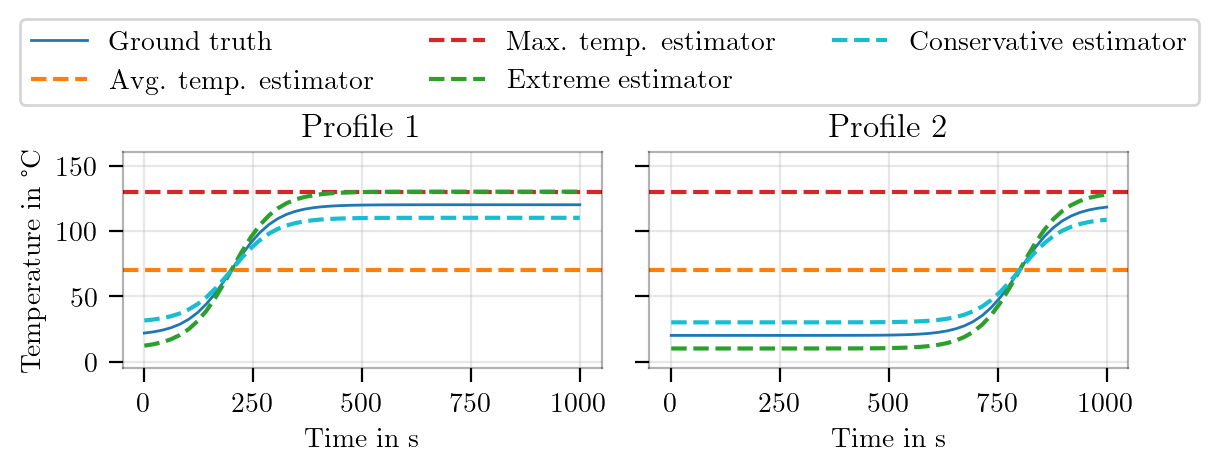

avg. temp            \
                                                   profile 1 profile 2   
MSE in K²                                             2017.2    2017.2   
Max.Temp. weighted MSE in K²                          2245.4    1536.9   
Max. Temp. weighted MSE with under-est-penalty ...    2263.8    1549.8   

                                                   max. temp            \
                                                   profile 1 profile 2   
MSE in K²                                             2097.8    9136.5   
Max.Temp. weighted MSE in K²                           412.3    2331.2   
Max. Temp. weighted MSE with under-est-penalty ...     412.3    2331.2   

                                                   conservative            \
                                                      profile 1 profile 2   
MSE in K²                                                  80.7      80.7   
Max.Temp. weighted MSE in K²                               89.8      61.5   
Max. Temp. weighted MSE with under-est-penalty ...         90.6      62.0   

                                                     extreme            
                                                   profile 1 profile 2  
MSE in K²                                               80.7      80.7  
Max.Temp. weighted MSE in K²                            89.8      61.5  
Max. Temp. weighted MSE with under-est-penalty ...      88.4      60.7

In [17]:
avg_temp = 70  # in °C
max_temp = 130  # in °C
x = np.linspace(0, 1000)

virt_scenarios = [
    avg_temp + 50*np.tanh((x-200)/100),
    avg_temp + 50*np.tanh((x - 800)/100),
]

ind_extreme_estimator_course = [(v-avg_temp)*1.2 + avg_temp for v in virt_scenarios]
ind_conservative_estimator_course = [(v-avg_temp)*0.8 + avg_temp for v in virt_scenarios]

# visualize scenarios
n_rows = 1
n_cols = len(virt_scenarios)
fig, axes = plt.subplots(1, len(virt_scenarios), figsize=(6.49, 1.4), sharey=True, sharex=True, dpi=200)
for i, (y, ax) in enumerate(zip(virt_scenarios, axes)):
    ax.plot(x, y, label='Ground truth', lw=1)
    ax.axhline(avg_temp, ls='dashed', color='tab:orange', label='Avg. temp. estimator')
    ax.axhline(max_temp, ls='dashed', color='tab:red', label='Max. temp. estimator')
    ax.plot(x, ind_extreme_estimator_course[i], label='Extreme estimator', ls='dashed', color='tab:green')
    ax.plot(x, ind_conservative_estimator_course[i], label='Conservative estimator', ls='dashed', color='tab:cyan')
    ax.set_xlabel('Time in s')
    if i == 0:
        ax.set_ylabel('Temperature in °C')
    ax.set_ylim(-5, 160)
    ax.set_title(f'Profile {i+1}')
    ax.set_yticks([0, 50, 100, 150])
    prettify(ax)

#fig.tight_layout()
ax.legend(ncol=3, loc='lower center', bbox_to_anchor=(.5, 1), bbox_transform=fig.transFigure)
fig.subplots_adjust(wspace=0.1)
fig.savefig(IMG_PATH /"3.2-metric_design.pdf", dpi=300, bbox_inches="tight")
# metrics

def max_temp_weighted_msle(y_true, y_pred, **kws):
    return mean_squared_log_error(y_true, y_pred, sample_weight=y_true/max_temp, **kws)

def msle1m(y_true, y_pred, **kws):
    target_dev_from_max = np.abs(2*max_temp - y_true)
    pred_dev_from_max = np.abs(2*max_temp - y_pred)
    return mean_squared_log_error(target_dev_from_max, 
                                  2*target_dev_from_max - pred_dev_from_max  , **kws)

def max_temp_weighted_mse(y_true, y_pred, **kws):
    return mean_squared_error(y_true, y_pred, sample_weight=(y_true/max_temp)**2, **kws)

def max_temp_weighted_mse_with_under_penalty(y_true, y_pred, **kws):
    under_penalty = (y_true - y_pred > 0).astype(int) + 1
    return mean_squared_error(y_true, y_pred, sample_weight=(y_true/max_temp)**2 * under_penalty, **kws)

scenario_lbls = [f'profile {vi+1}' for vi in range(len(virt_scenarios))]

estimators_d = {'avg. temp': [avg_temp*np.ones_like(x)]*len(virt_scenarios),
                 'max. temp': [max_temp*np.ones_like(x)]*len(virt_scenarios),
                 'conservative': ind_conservative_estimator_course,
                 'extreme': ind_extreme_estimator_course,}
metrics_d = {'MSE in K²': mean_squared_error,
             'Max.Temp. weighted MSE in K²': max_temp_weighted_mse,
             'Max. Temp. weighted MSE with under-est-penalty in K²': max_temp_weighted_mse_with_under_penalty,
             # 'MSLE p.u.': mean_squared_log_error, 
             #'Max.Temp. weighted MSLE p.u.': max_temp_weighted_msle,
             #'1m MSLE p.u': msle1m,
             }


performances_df = pd.DataFrame(columns=pd.MultiIndex.from_product([estimators_d.keys(), scenario_lbls]), 
                               index=metrics_d.keys())

for vi, vs in enumerate(virt_scenarios):
    for est_lbl, est in estimators_d.items():
        for mi, (m_lbl, m_func) in enumerate(metrics_d.items()):
            performances_df.loc[m_lbl, (est_lbl, f'profile {vi+1}')] = np.round(m_func(vs, est[vi]), 1)
            
plt.show()
performances_df

We find that putting a quadratic weighting on predictions depending on the ground truth target where maximum possible temperature receives a weight of 1^2 and the 0°C a weight of 0^2 multiplied with an underestimation weight of 2 (1°C underestimation is as crucial as 2°C overestimation) will improve training in the way we would like for our application.

See especially row 3 last column, where the extreme predictor has the best performance even though it is under estimating most of the time, but does an overestimation when it is critical.

In [18]:
print(performances_df.to_latex(label='tab:twmse', caption="Scores on two hypothetical profiles for different baselines"))

\begin{table}
\centering
\caption{Scores on two hypothetical profiles for different baselines}
\label{tab:twmse}
\begin{tabular}{lllllllll}
\toprule
{} & \multicolumn{2}{l}{avg. temp} & \multicolumn{2}{l}{max. temp} & \multicolumn{2}{l}{conservative} & \multicolumn{2}{l}{extreme} \\
{} & profile 1 & profile 2 & profile 1 & profile 2 &    profile 1 & profile 2 & profile 1 & profile 2 \\
\midrule
MSE in K²                                          &    2017.2 &    2017.2 &    2097.8 &    9136.5 &         80.7 &      80.7 &      80.7 &      80.7 \\
Max.Temp. weighted MSE in K²                       &    2245.4 &    1536.9 &     412.3 &    2331.2 &         89.8 &      61.5 &      89.8 &      61.5 \\
Max. Temp. weighted MSE with under-est-penalty ... &    2263.8 &    1549.8 &     412.3 &    2331.2 &         90.6 &      62.0 &      88.4 &      60.7 \\
\bottomrule
\end{tabular}
\end{table}

